In [1]:
from pathlib import Path

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import pandas as pd

from walmart_sales.constants import PROCESSED_DATA_DIR, PROCESSED_DATA_FILE
from walmart_sales.data import WalmartDataset, WalmartDataTransformer
from walmart_sales.evaluation import validate, mape, smape, wape
from walmart_sales.model import WalmartLGBM
from walmart_sales.visualization import plot_forecast_vs_target

In [2]:
df = pd.read_csv(Path("..", PROCESSED_DATA_DIR, PROCESSED_DATA_FILE), parse_dates=["Date"])

In [3]:
dataset = WalmartDataset(df)
transformer = WalmartDataTransformer()
lgbm_regressor = LGBMRegressor()
model = WalmartLGBM(lgbm_regressor, transformer)

# Data

In [4]:
len(dataset.full)

1384594

In [6]:
dataset.full.head()

,Store,Dept,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,...,lag_3,lag_2,lag_1,horizon,target,forecast_week,targeted_week,IsHoliday,Type,Size
0,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,42960.91,17596.96,16145.35,1,16555.11,2010-04-23,2010-04-30,False,A,151315.0
1,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,42960.91,17596.96,16145.35,2,17413.94,2010-04-23,2010-05-07,False,A,151315.0
2,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,42960.91,17596.96,16145.35,3,18926.74,2010-04-23,2010-05-14,False,A,151315.0
3,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,42960.91,17596.96,16145.35,4,14773.04,2010-04-23,2010-05-21,False,A,151315.0
4,1,2,50605.27,44682.74,47928.89,44292.87,48397.98,43751.94,43615.49,41892.55,...,46549.73,45025.02,44418.11,1,45971.30,2010-04-23,2010-04-30,False,A,151315.0


In [7]:
WalmartDataTransformer().fit_transform(dataset.full)[0].head()

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,horizon,store_size,store_type_A,store_type_B,is_holiday
0,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,17596.96,16145.35,1,151315.0,True,False,False
1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,17596.96,16145.35,2,151315.0,True,False,False
2,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,17596.96,16145.35,3,151315.0,True,False,False
3,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,17596.96,16145.35,4,151315.0,True,False,False
4,50605.27,44682.74,47928.89,44292.87,48397.98,43751.94,43615.49,41892.55,47450.50,46549.73,45025.02,44418.11,1,151315.0,True,False,False


# Validation

In [8]:
val_smape, _ = validate(dataset.val_ts_split, model, smape, verbose=True)
print(f"Validation SMAPE: {val_smape}")

Validating fold 1...
Validating fold 2...
Validating fold 3...
Validating fold 4...
Validating fold 5...
Validating fold 6...
Validating fold 7...
Validating fold 8...
Validating fold 9...
Validating fold 10...
Validating fold 11...
Validating fold 12...
Validation SMAPE: 18.512324597880355


## Test

In [9]:
test_smape, df_test_with_preds = validate(dataset.test_ts_split, model, smape, verbose=True)

Validating fold 1...
Validating fold 2...
Validating fold 3...
Validating fold 4...
Validating fold 5...
Validating fold 6...
Validating fold 7...
Validating fold 8...
Validating fold 9...
Validating fold 10...
Validating fold 11...
Validating fold 12...


In [10]:
test_smape

19.115286033973973

In [11]:
smape_by_horizon = df_test_with_preds.groupby("horizon").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_index()
smape_by_horizon

,smape,data points,departments
horizon,,,
1,16.631940,32113.0,2681.0
2,18.846207,29438.0,2681.0
3,20.337317,26762.0,2680.0
4,21.397311,24086.0,2679.0


<Axes: xlabel='horizon', ylabel='SMAPE'>

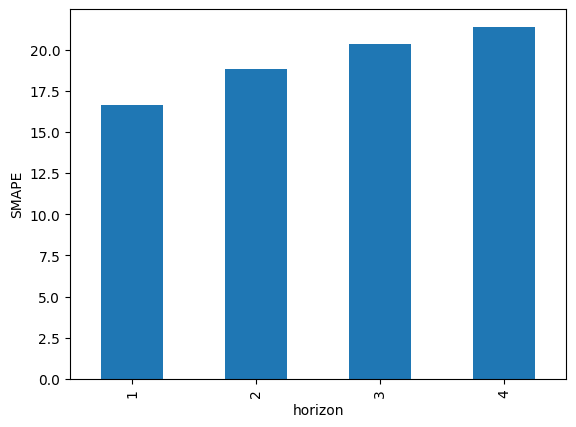

In [12]:
plt.ylabel("SMAPE")
smape_by_horizon["smape"].plot.bar()

In [13]:
smape_by_department = df_test_with_preds.groupby("Dept").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_values("smape")
smape_by_department

,smape,data points,departments
Dept,,,
8,4.548392,1890.0,45.0
40,4.807532,1890.0,45.0
90,5.364860,1890.0,45.0
94,6.161914,1176.0,28.0
13,6.211445,1890.0,45.0
...,...,...,...
36,52.307108,1512.0,36.0
59,71.267749,1428.0,34.0
54,155.045748,42.0,1.0


<Axes: xlabel='Dept', ylabel='SMAPE'>

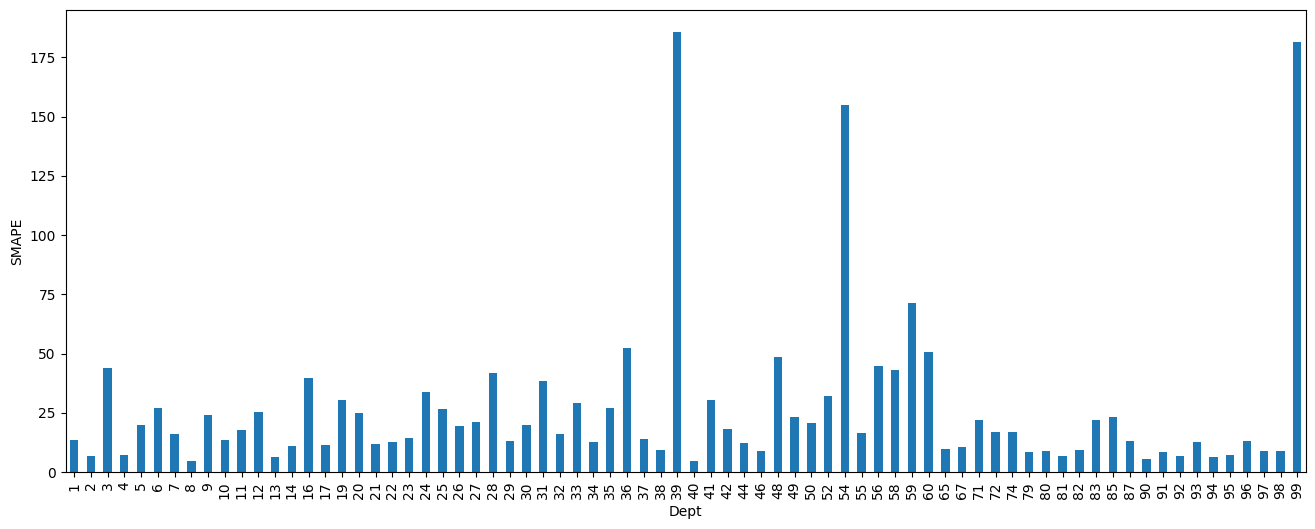

In [14]:
plt.figure(figsize=(16,6))
plt.ylabel("SMAPE")
smape_by_department["smape"].sort_index().plot.bar()

In [15]:
smape_by_forecast_week = df_test_with_preds.groupby("forecast_week").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_index()
smape_by_forecast_week

,smape,data points,departments
forecast_week,,,
2012-08-03,18.898473,10703.0,2678.0
2012-08-10,19.893160,10704.0,2678.0
2012-08-17,20.708913,10706.0,2679.0
2012-08-24,21.225421,10706.0,2678.0
2012-08-31,21.933832,10706.0,2678.0
2012-09-07,20.956044,10707.0,2679.0
2012-09-14,17.982042,10705.0,2677.0
2012-09-21,17.037282,10705.0,2677.0
2012-09-28,17.054403,10704.0,2677.0


<Axes: xlabel='forecast_week'>

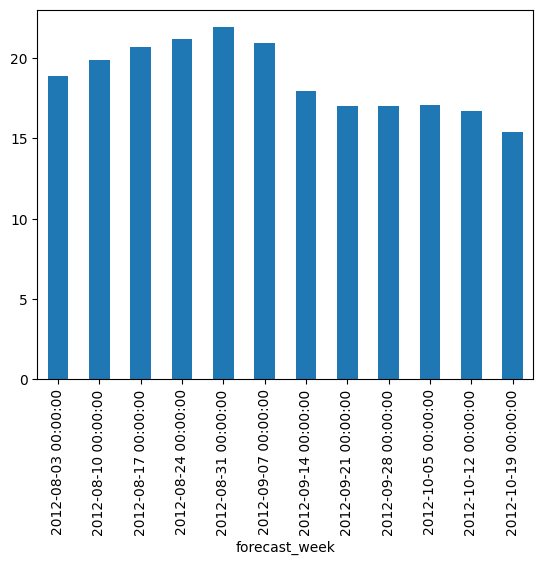

In [16]:
smape_by_forecast_week["smape"].plot.bar()

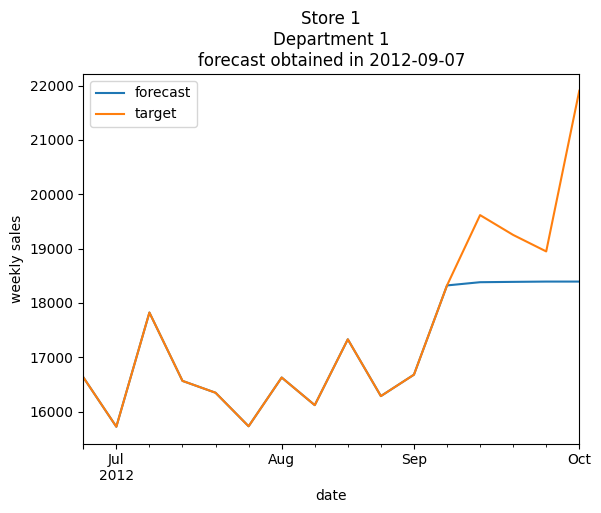

In [17]:
plot_forecast_vs_target(df_test_with_preds, 1, 1, "2012-09-07")

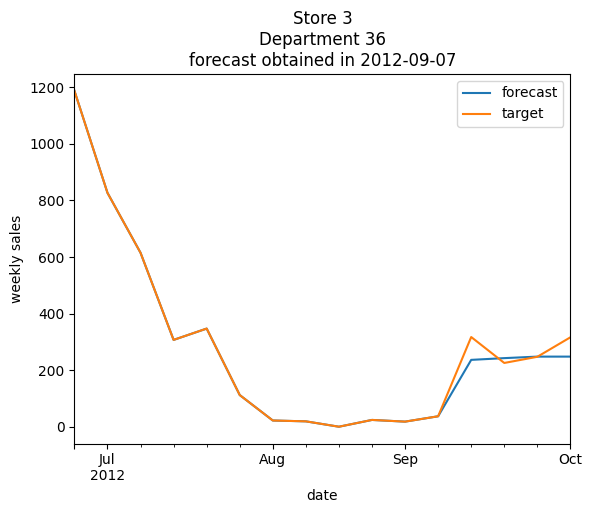

In [18]:
plot_forecast_vs_target(df_test_with_preds, 3, 36, "2012-09-07")

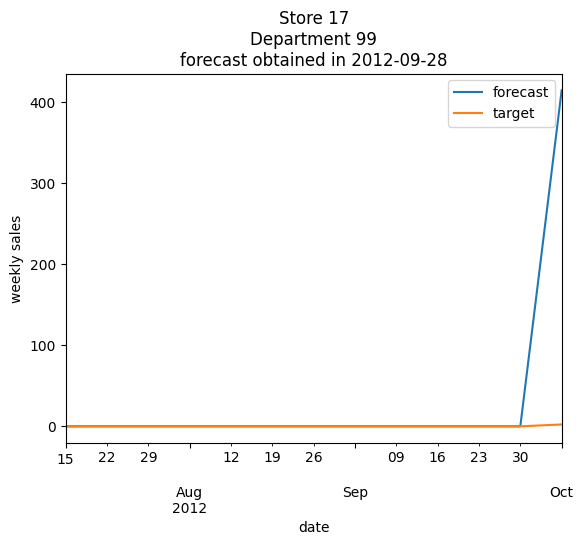

In [19]:
plot_forecast_vs_target(df_test_with_preds, 17, 99, "2012-09-28")